## 0. Import Modules

In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import distributions
import datetime
import pandas as pd
import pandas_datareader.data as pdr
from options_chains import OptionsChain
from models import ARCHForecastModel
import arch
import py_vollib.black_scholes as black_scholes_merton
import py_vollib_vectorized

Observed autocorrelative returns behaviour suggests returns follow ARCH behaviour

# 1. Testing GARCH and EGARCH Models on Returns Data

In [3]:
"""
Making training, and testing datasets
Training set is SPY returns from 2014
Testing set is SPY returns in 2019 
"""
spy_returns = distributions.get_returns(["SPY"], "2014-01-01", "2020-01-01")
spy_data = pd.DataFrame({"Log Returns":spy_returns})
spy_data = spy_data.dropna(axis=0, how="all")
spy_data.index = pd.to_datetime(spy_data.index)
spy_data["Realized Volatility"] = distributions.get_realized_volatility(spy_data["Log Returns"],21)

[*********************100%%**********************]  1 of 1 completed


### 1.1 GARCH Model for SPY

In [4]:
split_date = datetime.datetime(2019,1,1)
spy_model = arch.arch_model(spy_data["Log Returns"] * 100, mean="Constant", p=1, q=1)
res = spy_model.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 19777.609257667948
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1121775.021046559
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1455.5021306817835
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1667.4040806136118
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1371.8010229588103
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2003.1197106658879
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1373.1696391036235
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1367.3142468613905
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1367.210525081328
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1367.2104067117725
Iteration:     11,   Func. Count:     69,   Neg. LLF: 1367.210405668181
Iteration:     12,   Func. Count:     73,   Neg. LLF: 1367.210405668569
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1367.210405668181
            Iteratio

In [5]:
res.summary()

/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/a

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1367.21
Distribution:                  Normal   AIC:                           2742.42
Method:            Maximum Likelihood   BIC:                           2762.97
                                        No. Observations:                 1257
Date:                Tue, Jan 30 2024   Df Residuals:                     1256
Time:                        13:04:39   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0747  1.770e-02      4.219  2.451e-05 [4.000e-02,  0.109]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0422  1.341e-02      3.151  1.626e-03 [1.597e-02,6.852e-02]
alpha[1]       0.2037  4.194e-02      4.858  1.184e-06     [  0.122,  0.286]
beta[1]        0.7432  4.269e-02     17.407  7.323e-68     [  0.660,  0.827]
============================================================================

Covariance estimator: robust
"""

In [6]:
res.arch_lm_test()

ARCH-LM Test
H0: Residuals are homoskedastic.
ARCH-LM Test
H1: Residuals are conditionally heteroskedastic.
Statistic: 210.3010
P-value: 0.0000
Distributed: chi2(23)
WaldTestStatistic, id: 0x176ab74c0

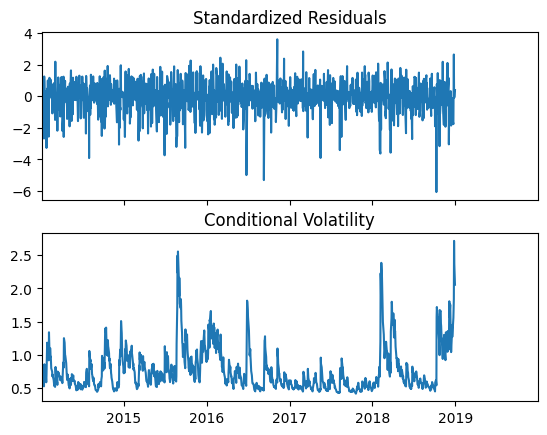

In [7]:
fig = res.plot()

Text(0.5, 1.0, 'GARCH Conditional Volatility vs. Realized Volatility from Training Data')

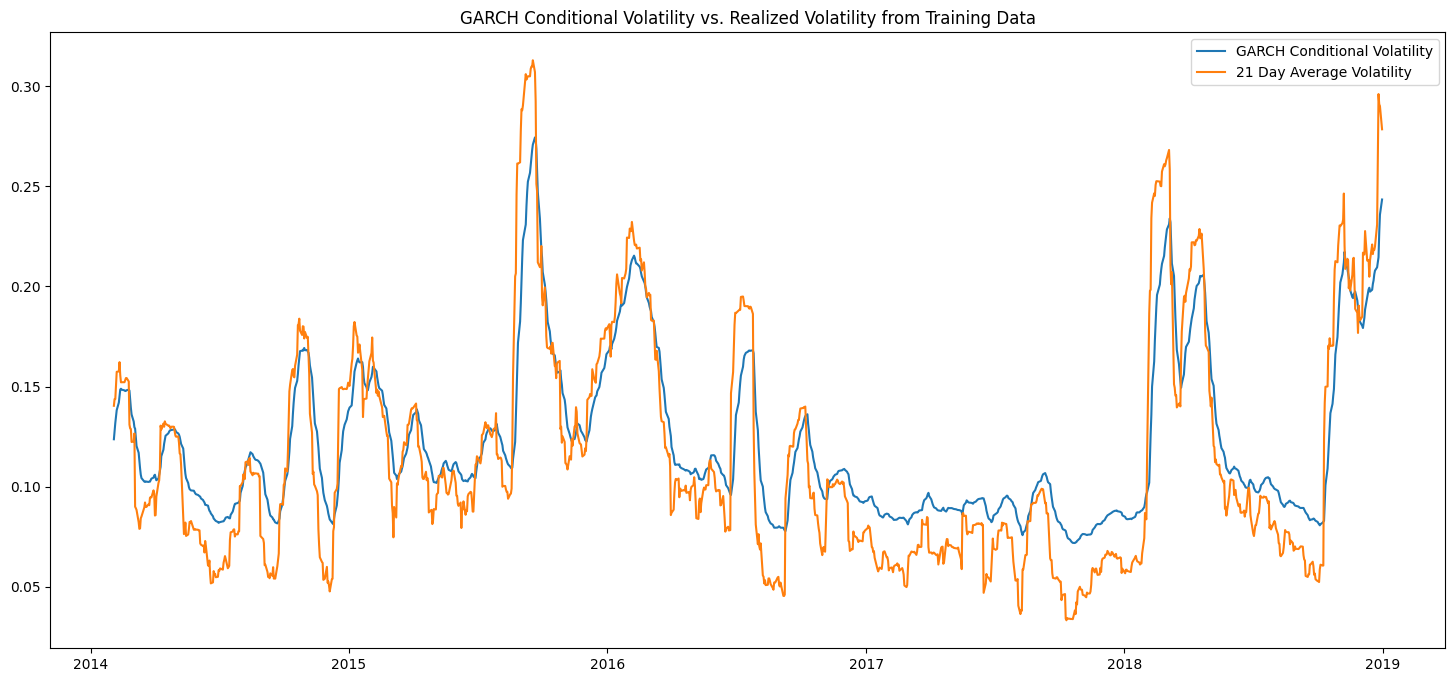

In [8]:
fig = plt.figure(figsize=(18, 8))
plt.plot(res.conditional_volatility.rolling(window=21).mean()*np.sqrt(252)/100)
plt.plot(distributions.get_realized_volatility(spy_data["Log Returns"], 21)[:split_date])
plt.legend(["GARCH Conditional Volatility","21 Day Average Volatility"])
plt.title("GARCH Conditional Volatility vs. Realized Volatility from Training Data")

In [9]:
forecasts = res.forecast(horizon=21, start=split_date, method="simulation")

In [10]:
month_forecast = pd.DataFrame({"Forecasted Volatility":(forecasts.variance.mean(axis=1)/100 * np.sqrt(252))[:-21]}, 
                              index = forecasts.variance.index[21:])

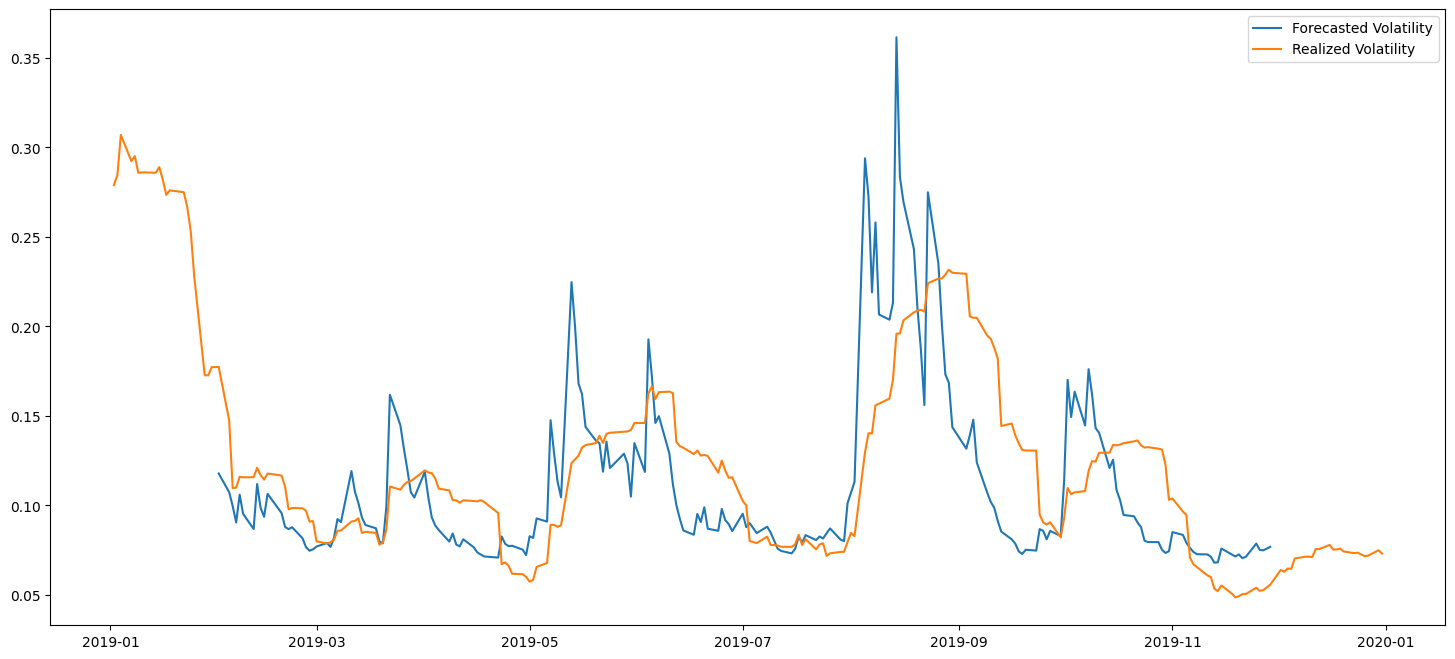

In [11]:
fig = plt.figure(figsize = (18, 8))
plt.plot(month_forecast)
plt.plot(spy_data["Realized Volatility"][split_date:])
plt.legend(["Forecasted Volatility", "Realized Volatility"])

<Axes: ylabel='Density'>

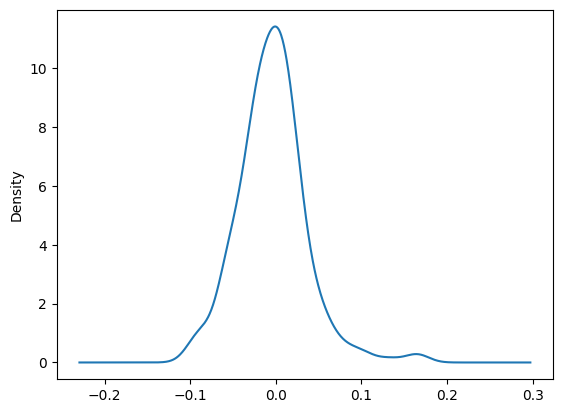

In [12]:
residuals = (month_forecast["Forecasted Volatility"]) - spy_data["Realized Volatility"]
residuals.plot(kind="kde")

<Axes: ylabel='Density'>

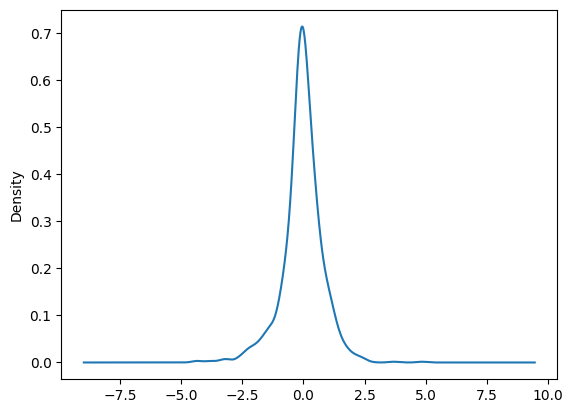

In [13]:
res.resid.plot(kind="kde")

In [14]:
returns_forecast = pd.DataFrame(
    {"Forecasted Returns": np.mean(forecasts.simulations.values[:-21,:,-1], axis=1)/100}, 
    index = forecasts.variance.index[21:]
    )

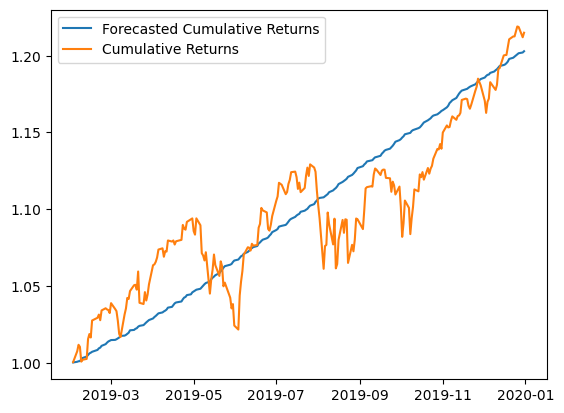

In [15]:
returns_forecast["Forecasted Cumulative Returns"] = np.mean(np.exp((forecasts.simulations.values[:-21,:,-1]/100).cumsum(axis=0)), axis=1)
spy_data["Cumulative Returns"] = np.exp((spy_data[spy_data.index >= split_date].iloc[21:]["Log Returns"]).cumsum())
plt.plot(returns_forecast["Forecasted Cumulative Returns"])
plt.plot(spy_data["Cumulative Returns"])
plt.legend(["Forecasted Cumulative Returns", "Cumulative Returns"])

### 1.2 EGARCH Model for SPY

In [16]:
spy_egarch = arch.arch_model(spy_data["Log Returns"] * 100, mean="Zero", p=2, q=2, vol="EGARCH")
egarch_res = spy_egarch.fit(last_obs=split_date)

Iteration:      1,   Func. Count:      7,   Neg. LLF: 239782037.53646886
Iteration:      2,   Func. Count:     17,   Neg. LLF: 320359332.4321431
Iteration:      3,   Func. Count:     26,   Neg. LLF: 89982766.8723636
Iteration:      4,   Func. Count:     34,   Neg. LLF: 2058.0433799711855
Iteration:      5,   Func. Count:     42,   Neg. LLF: 727176377.2049801
Iteration:      6,   Func. Count:     49,   Neg. LLF: 1386.3855502256101
Iteration:      7,   Func. Count:     55,   Neg. LLF: 1389.764980043101
Iteration:      8,   Func. Count:     64,   Neg. LLF: 1386.1944571948247
Iteration:      9,   Func. Count:     71,   Neg. LLF: 1385.4760932780305
Iteration:     10,   Func. Count:     77,   Neg. LLF: 1385.4621821762694
Iteration:     11,   Func. Count:     83,   Neg. LLF: 1385.4604205364385
Iteration:     12,   Func. Count:     89,   Neg. LLF: 1385.4603044231048
Iteration:     13,   Func. Count:     95,   Neg. LLF: 1385.4602974581223
Iteration:     14,   Func. Count:    100,   Neg. LLF: 13

In [17]:
egarch_res.summary()

/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/arch/univariate/base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/arch/univariate/base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
/Users/tayo4pf/Library/CloudStorage/OneDrive-UniversityofCambridge/part-ii-dissertation/arm_venv/lib/python3.10/site-packages/a

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - EGARCH Model Results                       
==============================================================================
Dep. Variable:            Log Returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -1385.46
Distribution:                  Normal   AIC:                           2780.92
Method:            Maximum Likelihood   BIC:                           2806.60
                                        No. Observations:                 1257
Date:                Tue, Jan 30 2024   Df Residuals:                     1257
Time:                        13:04:41   Df Model:                            0
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega         -0.0649  3.404e-02     -1.907  5.657e-02 [ -0.132,1.817e-03]
alpha[1]       0.3301  6.580e-02      5.018  5.228e-07   [  0.201,  0.459]
alpha[2]       0.3969  7.659e-02      5.183  2.188e-07   [  0.247,  0.547]
beta[1]    3.2524e-18  6.102e-02  5.330e-17      1.000   [ -0.120,  0.120]
beta[2]        0.8133  4.317e-02     18.840  3.574e-79   [  0.729,  0.898]
==========================================================================

Covariance estimator: robust
"""

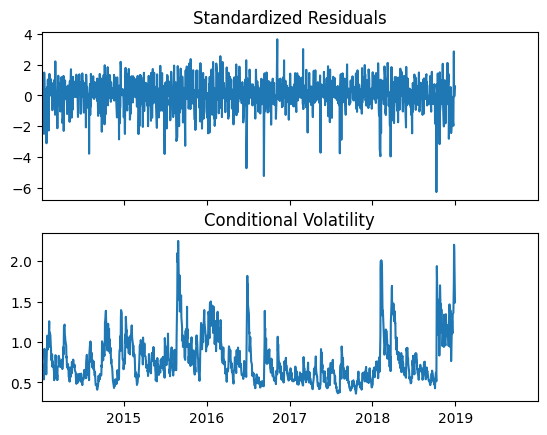

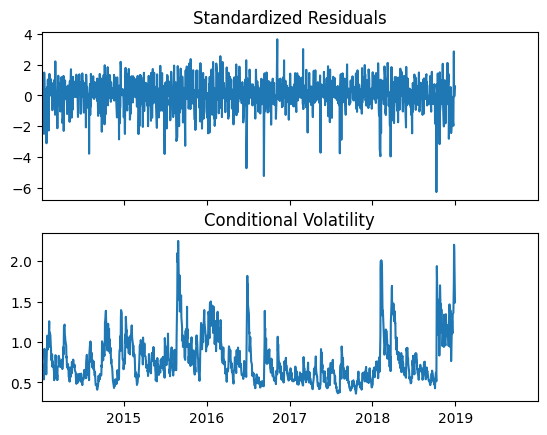

In [18]:
egarch_res.plot()

Text(0.5, 1.0, 'Scaled GARCH Conditional Volatility vs. Realized Volatility for Training Data')

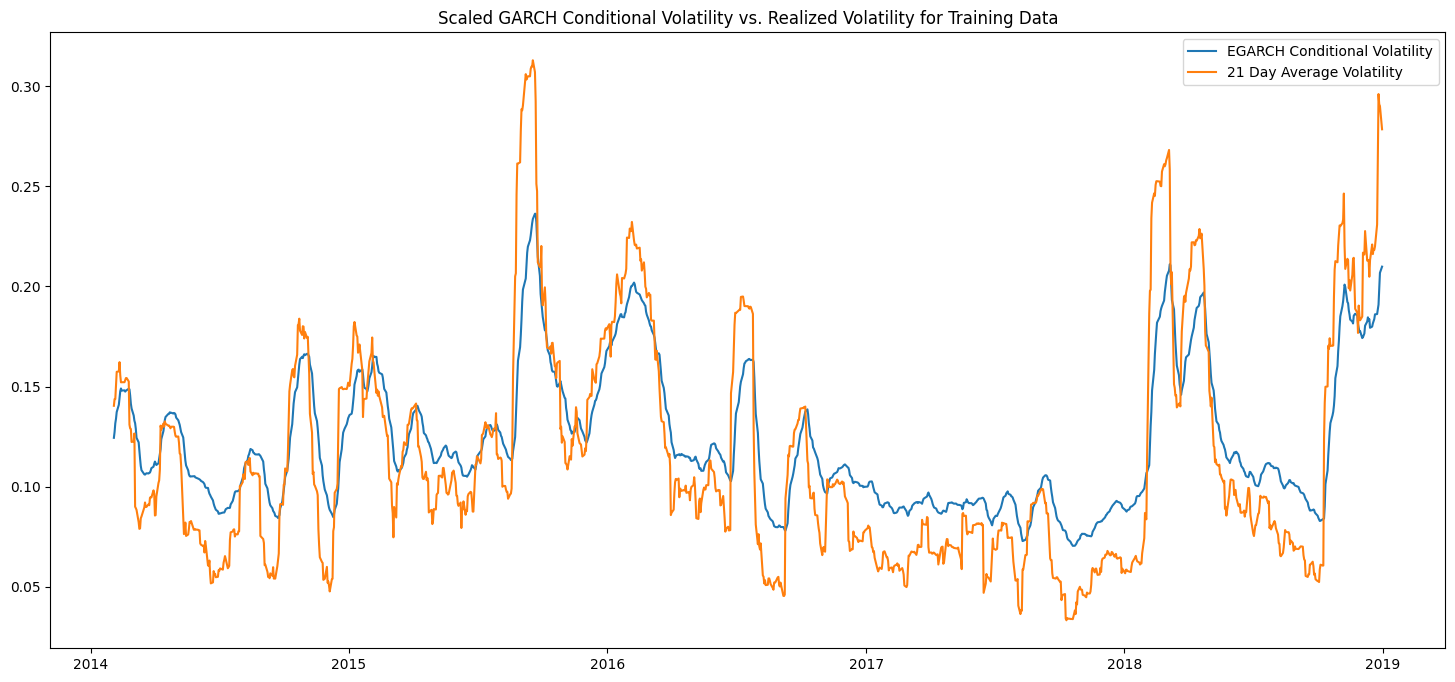

In [19]:
fig = plt.figure(figsize=(18, 8))
plt.plot(egarch_res.conditional_volatility.rolling(window=21).mean()*np.sqrt(252)/100)
plt.plot(distributions.get_realized_volatility(spy_data["Log Returns"], 21)[:split_date])
plt.legend([ "EGARCH Conditional Volatility","21 Day Average Volatility"])
plt.title("Scaled GARCH Conditional Volatility vs. Realized Volatility for Training Data")

In [20]:
egarch_forecasts = egarch_res.forecast(horizon=21, method="simulation", start=split_date)

In [21]:
egarch_month_forecast = pd.DataFrame(
    {"Forecasted Volatility":(egarch_forecasts.variance.mean(axis=1) * np.sqrt(252)/100)[:-21]}, 
    index = egarch_forecasts.variance.index[21:]
    )

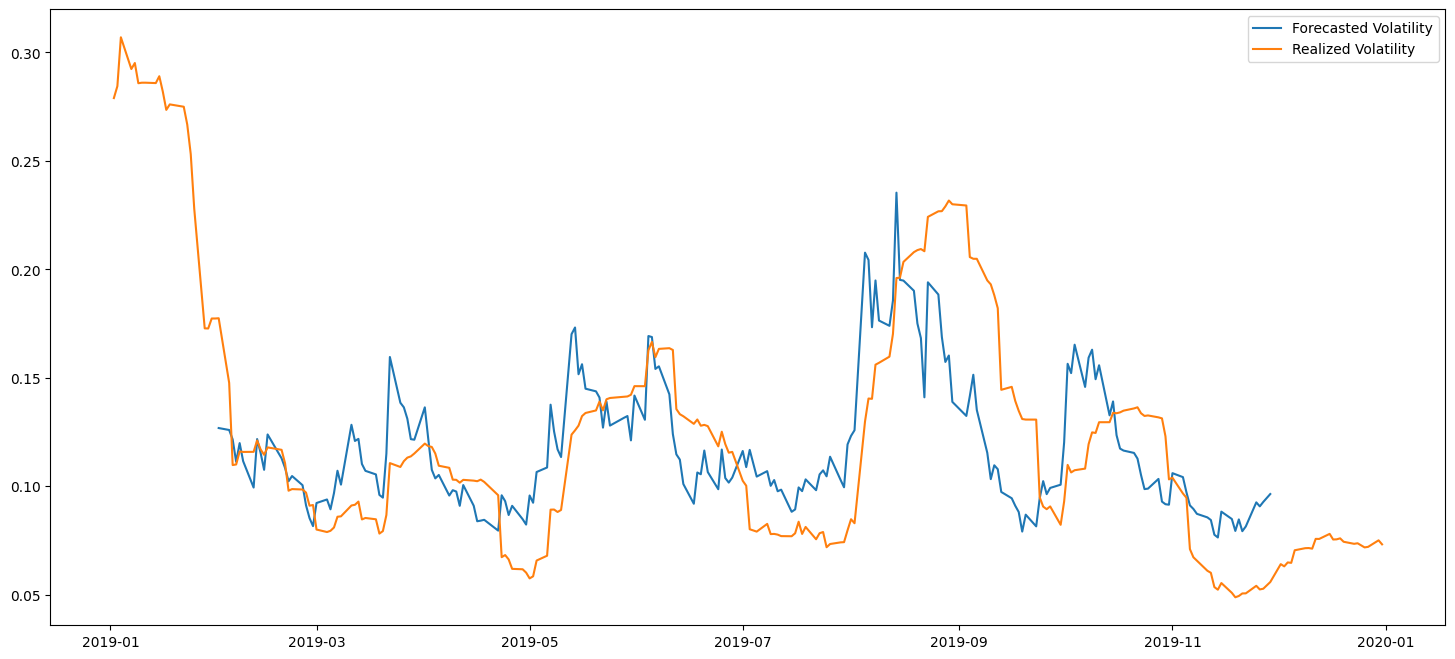

In [22]:
fig = plt.figure(figsize = (18, 8))
plt.plot(egarch_month_forecast)
plt.plot(spy_data["Realized Volatility"][split_date:])
plt.legend(["Forecasted Volatility", "Realized Volatility"])

In [23]:
egarch_residuals = month_forecast["Forecasted Volatility"] - spy_data["Realized Volatility"][split_date:]

<Axes: ylabel='Density'>

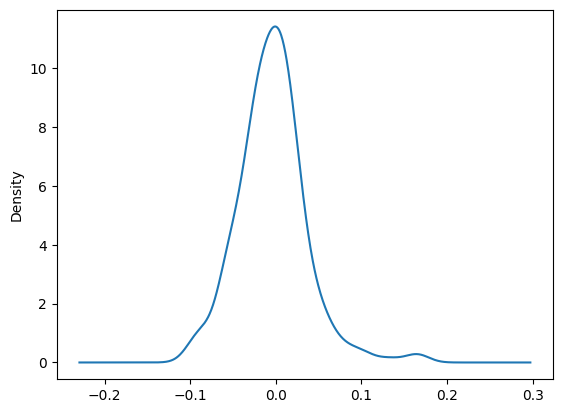

In [24]:
egarch_residuals.plot(kind="kde")

<Axes: ylabel='Density'>

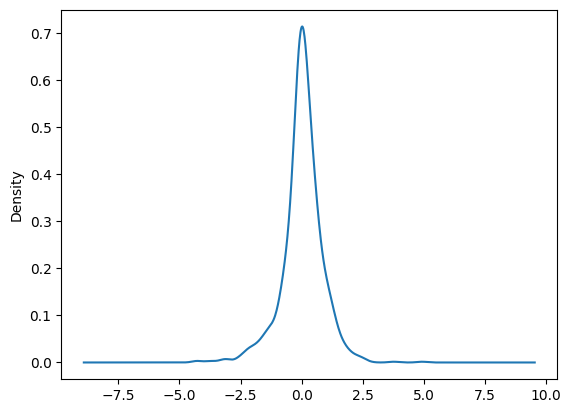

In [25]:
egarch_res.resid.plot(kind="kde")

In [26]:
egarch_returns_forecast = pd.DataFrame(
    {"Forecasted Returns": np.mean(egarch_forecasts.simulations.values[:-21,:,-1], axis=1)/100}, 
    index = egarch_forecasts.variance.index[21:]
    )

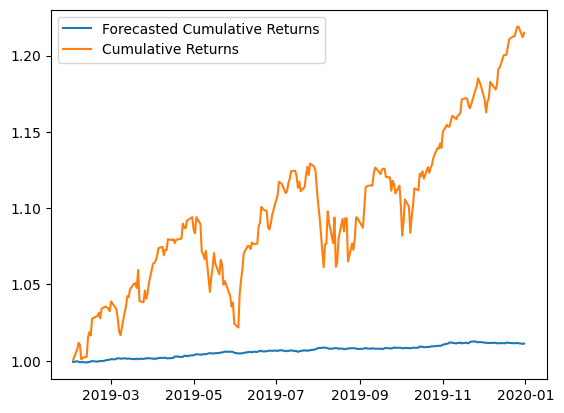

In [27]:
egarch_returns_forecast["Forecasted Cumulative Returns"] = np.mean(np.exp((egarch_forecasts.simulations.values[:-21,:,-1]/100).cumsum(axis=0)), axis=1)
spy_data["Cumulative Returns"] = np.exp((spy_data[spy_data.index >= split_date].iloc[21:]["Log Returns"]).cumsum())
plt.plot(egarch_returns_forecast["Forecasted Cumulative Returns"])
plt.plot(spy_data["Cumulative Returns"])
plt.legend(["Forecasted Cumulative Returns", "Cumulative Returns"])

# 2. Contract Simulation

### 2.0 Loading data on options chains from 2019

In [28]:
options = OptionsChain("SPY", 2019)

In [29]:
iv_dist = options.iv_dist(21, 0.45, 0.55)
ask_dist = options.ask_dist(21, 0.45, 0.55)
bid_dist = options.bid_dist(21, 0.45, 0.55)

#### 2.0.0 Naive Volatility Comparison

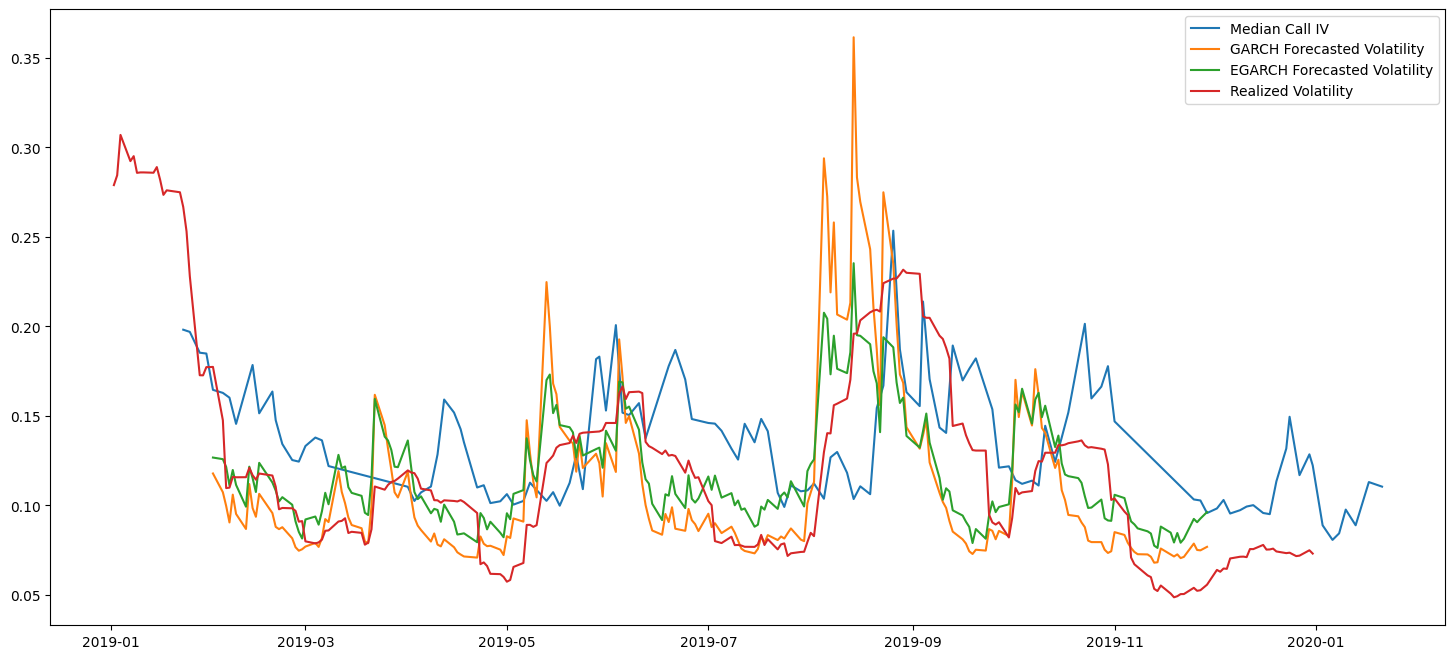

In [30]:
fig = plt.figure(figsize = (18,8))
plt.plot(iv_dist["C IV", "median"])
plt.plot(month_forecast)
plt.plot(egarch_month_forecast)
plt.plot(spy_data["Realized Volatility"][split_date:])
plt.legend(["Median Call IV", "GARCH Forecasted Volatility", "EGARCH Forecasted Volatility", "Realized Volatility"])

In [31]:
market_residuals = iv_dist["C IV", "median"] - spy_data["Realized Volatility"]

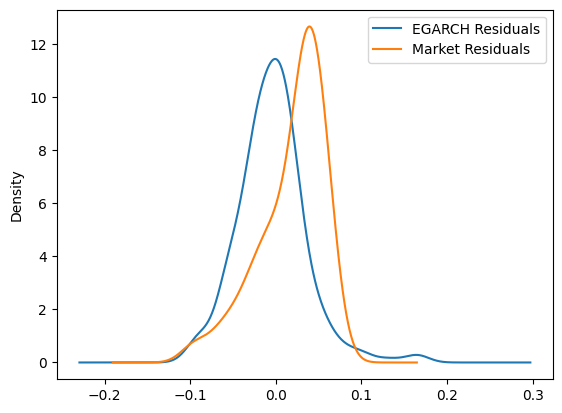

In [32]:
fig = plt.figure()
axes = plt.axes()
egarch_residuals.plot(kind="kde", ax=axes)
market_residuals.plot(kind="kde", ax=axes)
plt.legend(["EGARCH Residuals", "Market Residuals"])

In [33]:
print(f"Market median implied volatility has residuals with mean: {np.mean(market_residuals)},\n\
and standard deviation: {np.std(market_residuals)},\n\
the EGARCH model forecasted volatility has residuals with mean: {np.mean(egarch_residuals)},\n\
and standard deviation: {np.std(egarch_residuals)}")

Market median implied volatility has residuals with mean: 0.018334217694108434,
and standard deviation: 0.038144108229464575,
the EGARCH model forecasted volatility has residuals with mean: -0.004017667997339109,
and standard deviation: 0.03980935577571008


In [34]:
def sim_call_option_ev(simulations, s, k):
    """
    Function to find the expected value of an option using Monte Carlo estimation
    simulations: an nparray, indexed by timestep within the expiration period, then simulation
    s: current price of the underlying
    k: strike price of the option
    """
    value_over_period = ((s * np.exp(simulations.sum(axis=1))) - k)
    value_over_period[value_over_period < 0] = 0
    ev = np.mean(value_over_period)
    return ev

#### 2.0.1 Loading TBill Data

In [35]:
t_bill_rates = pdr.DataReader("DGS1MO", "fred", "2019-01-01", "2020-01-01")/100
t_bill_rates.head()

,DGS1MO
DATE,
2019-01-01,NaN
2019-01-02,0.0240
2019-01-03,0.0242
2019-01-04,0.0240
2019-01-07,0.0242


### 2.1 GARCH Simulation

#### 2.1.0 Creating Simulations

In [36]:
arch_forecaster = ARCHForecastModel("SPY", "2014-01-01", "2020-01-01", "2019-01-01", "GARCH", 1, 1, 21)
arch_forecaster.forecaster(21)
simulator = arch_forecaster.simulation(21)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
Iteration:      1,   Func. Count:      6,   Neg. LLF: 19777.609257667948
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1121775.021046559
Iteration:      3,   Func. Count:     22,   Neg. LLF: 1455.5021306817835
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1667.4040806136118
Iteration:      5,   Func. Count:     35,   Neg. LLF: 1371.8010229588103
Iteration:      6,   Func. Count:     41,   Neg. LLF: 2003.1197106658879
Iteration:      7,   Func. Count:     47,   Neg. LLF: 1373.1696391036235
Iteration:      8,   Func. Count:     53,   Neg. LLF: 1367.3142468613905
Iteration:      9,   Func. Count:     59,   Neg. LLF: 1367.210525081328
Iteration:     10,   Func. Count:     64,   Neg. LLF: 1367.2104067117725
Iteration:     11,   Func. Count:     69,   Neg. LLF: 1367.210405668181
Iteration:     12,   Func. Count:     73,   Neg. LLF: 1367.210405668569
Optimization terminated successfully    (Exit mode 0)
    

In [37]:
garch_pricing = arch_forecaster.options_pricing(simulator, 1, shift=True)
garch_pricing.head()

,Call Price ATM,Realized Call Value ATM,Put Price ATM,Realized Put Value ATM,Underlying Price
Date,,,,,
2019-02-01,7.808963,18.320709,3.678217,0.0,230.557465
2019-02-04,8.092186,25.573410,3.940956,0.0,225.055725
2019-02-05,9.381734,19.085678,5.141193,0.0,232.594086
2019-02-06,8.948962,16.919891,4.394174,0.0,234.428040
2019-02-07,8.060342,12.321396,3.989959,0.0,236.630585


#### 2.1.1 Comparing Simulations to Realized Data

Call Analysis

<Axes: xlabel='Date'>

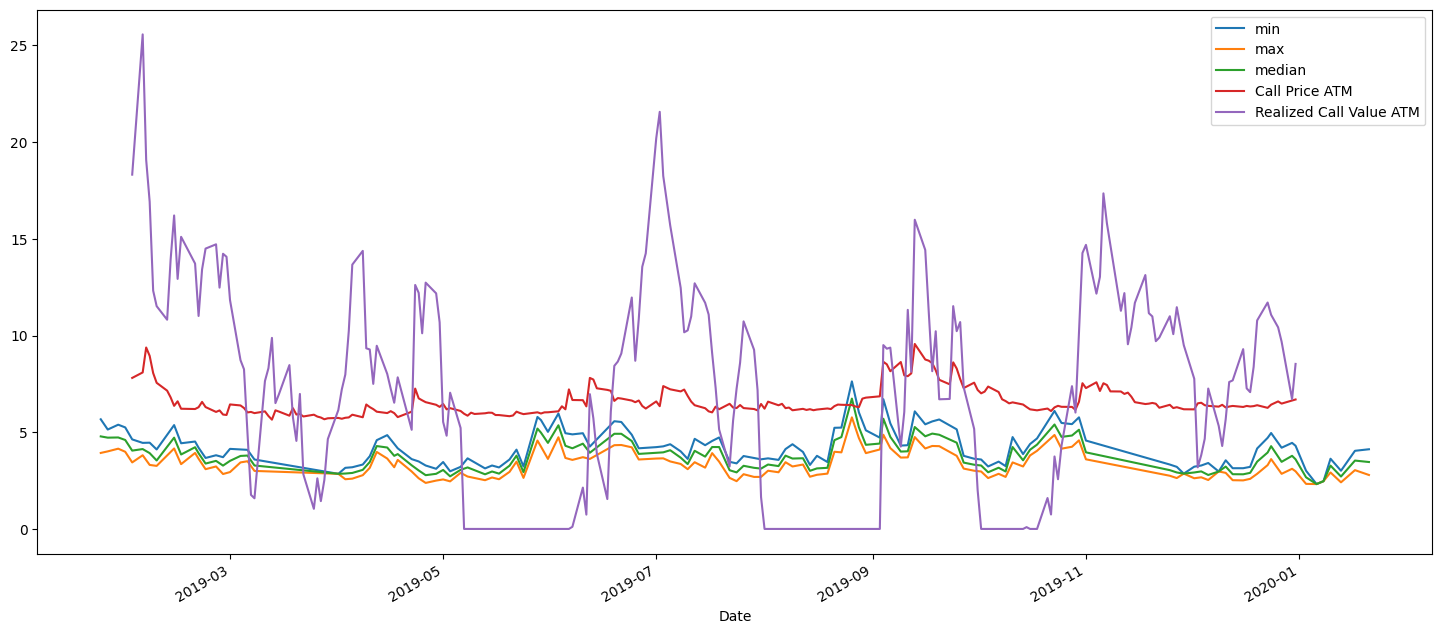

In [38]:
fig = plt.figure(figsize=(18,8))
ax = plt.axes()
ask_dist["C ASK"].plot(ax=ax)
garch_pricing[["Call Price ATM", "Realized Call Value ATM"]].plot(ax=ax)

In [39]:
garch_pricing["Call Residuals"] = garch_pricing["Call Price ATM"] - garch_pricing["Realized Call Value ATM"]
call_ask_residuals = ask_dist["C ASK"]["median"] - garch_pricing["Realized Call Value ATM"]

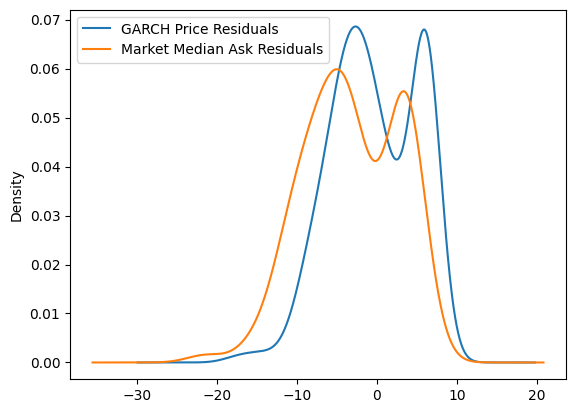

In [40]:
ax = plt.axes()
garch_pricing["Call Residuals"].plot(kind="kde", ax=ax)
call_ask_residuals.plot(kind="kde", ax=ax)
plt.legend(["GARCH Price Residuals", "Market Median Ask Residuals", "Market Median Bid Residuals"])

In [41]:
print(f"Regarding calls, the market ask price has a mean residual of {np.mean(call_ask_residuals)}\
 and a standard deviation of {np.std(call_ask_residuals)},\nthe GARCH Model has a mean residual of\
 {np.mean(garch_pricing['Call Residuals'])} and a standard deviation of {np.std(garch_pricing['Call Residuals'])}")

Regarding calls, the market ask price has a mean residual of -3.158915482208508 and a standard deviation of 5.819085415588201,
the GARCH Model has a mean residual of -0.29975797194813825 and a standard deviation of 5.270590675590053


Put Analysis

<Axes: xlabel='Date'>

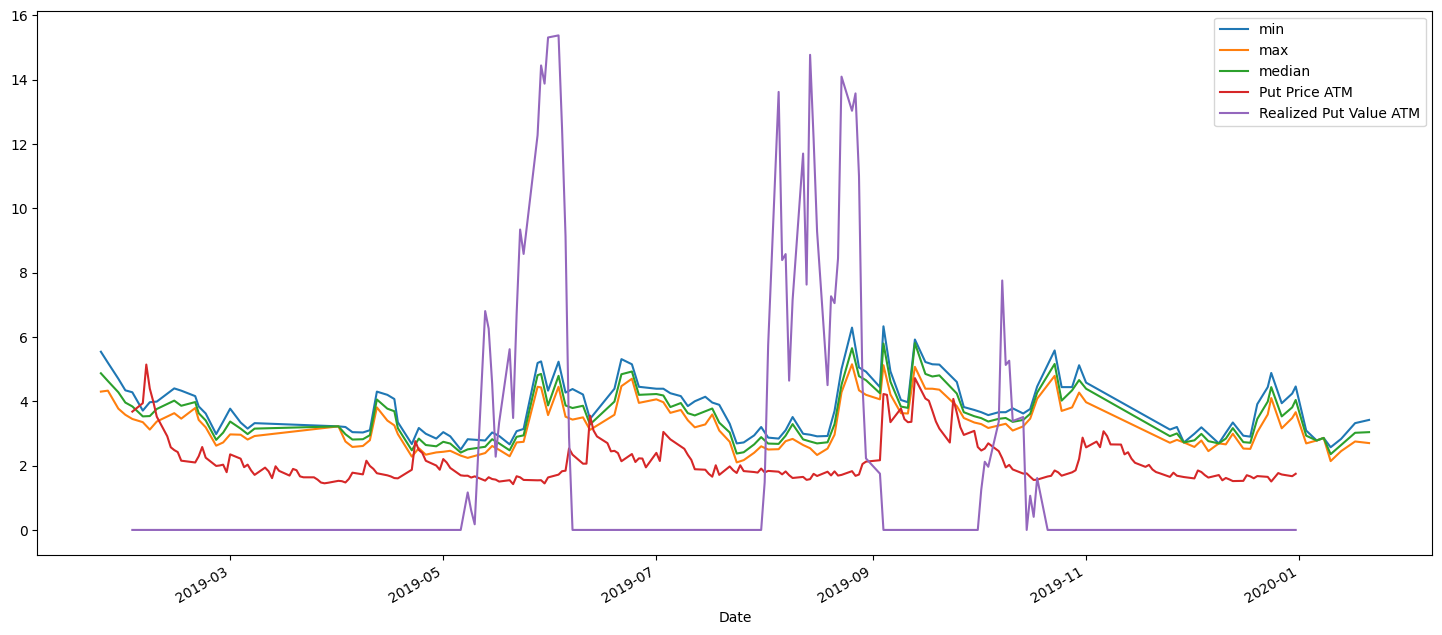

In [42]:
fig = plt.figure(figsize=(18,8))
ax = plt.axes()
ask_dist["P ASK"].plot(ax=ax)
garch_pricing[["Put Price ATM", "Realized Put Value ATM"]].plot(ax=ax)

In [43]:
garch_pricing["Put Residuals"] = garch_pricing["Put Price ATM"] - garch_pricing["Realized Put Value ATM"]
put_ask_residuals = ask_dist["P ASK"]["median"] - garch_pricing["Realized Put Value ATM"]

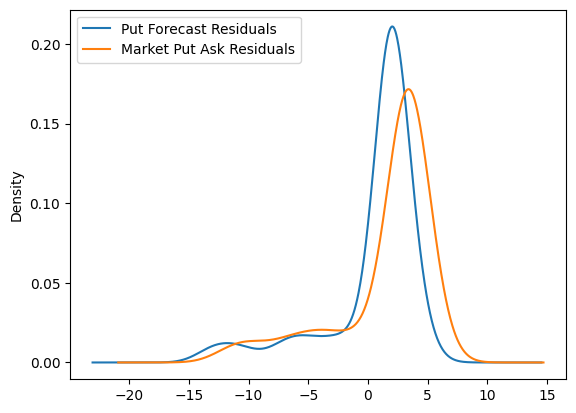

In [44]:
ax = plt.axes()
garch_pricing["Put Residuals"].plot(kind="kde",ax=ax)
put_ask_residuals.plot(kind="kde",ax=ax)
plt.legend(["Put Forecast Residuals", "Market Put Ask Residuals"])

In [45]:
print(f"Regarding puts, the market ask price has a mean residual of {np.mean(put_ask_residuals)}\
 and a standard deviation of {np.std(put_ask_residuals)},\nthe GARCH Model has a mean residual of\
 {np.mean(garch_pricing['Put Residuals'])} and a standard deviation of {np.std(garch_pricing['Put Residuals'])}")

Regarding puts, the market ask price has a mean residual of 1.456157303497571 and a standard deviation of 4.156461390654912,
the GARCH Model has a mean residual of 0.47935236694994376 and a standard deviation of 3.935553943686715


Forecast Implied Volatility

In [46]:
garch_pricing = garch_pricing.join(t_bill_rates.shift(21), how="left")
garch_pricing = garch_pricing.dropna(axis=0, subset="Call Price ATM")

In [47]:
garch_pricing.head()

,Call Price ATM,Realized Call Value ATM,Put Price ATM,Realized Put Value ATM,Underlying Price,Call Residuals,Put Residuals,DGS1MO
Date,,,,,,,,
2019-02-01,7.808963,18.320709,3.678217,0.0,230.557465,-10.511747,3.678217,0.0242
2019-02-04,8.092186,25.573410,3.940956,0.0,225.055725,-17.481224,3.940956,0.0240
2019-02-05,9.381734,19.085678,5.141193,0.0,232.594086,-9.703944,5.141193,0.0242
2019-02-06,8.948962,16.919891,4.394174,0.0,234.428040,-7.970929,4.394174,0.0240
2019-02-07,8.060342,12.321396,3.989959,0.0,236.630585,-4.261054,3.989959,0.0240


In [48]:
ticker_symbol = 'SPY'
stock = yf.Ticker(ticker_symbol)
info = stock.info

dividend_yield = info["yield"]

In [49]:
#TODO: Continuous Dividend Rate
garch_pricing["Call IV ATM"] = black_scholes_merton.implied_volatility.implied_volatility(
    garch_pricing["Call Price ATM"], 
    garch_pricing["Underlying Price"],
    garch_pricing["Underlying Price"],
    21/251,
    garch_pricing["DGS1MO"]**12,
    ["c"],
    [dividend_yield],
    return_as="numpy"
    )

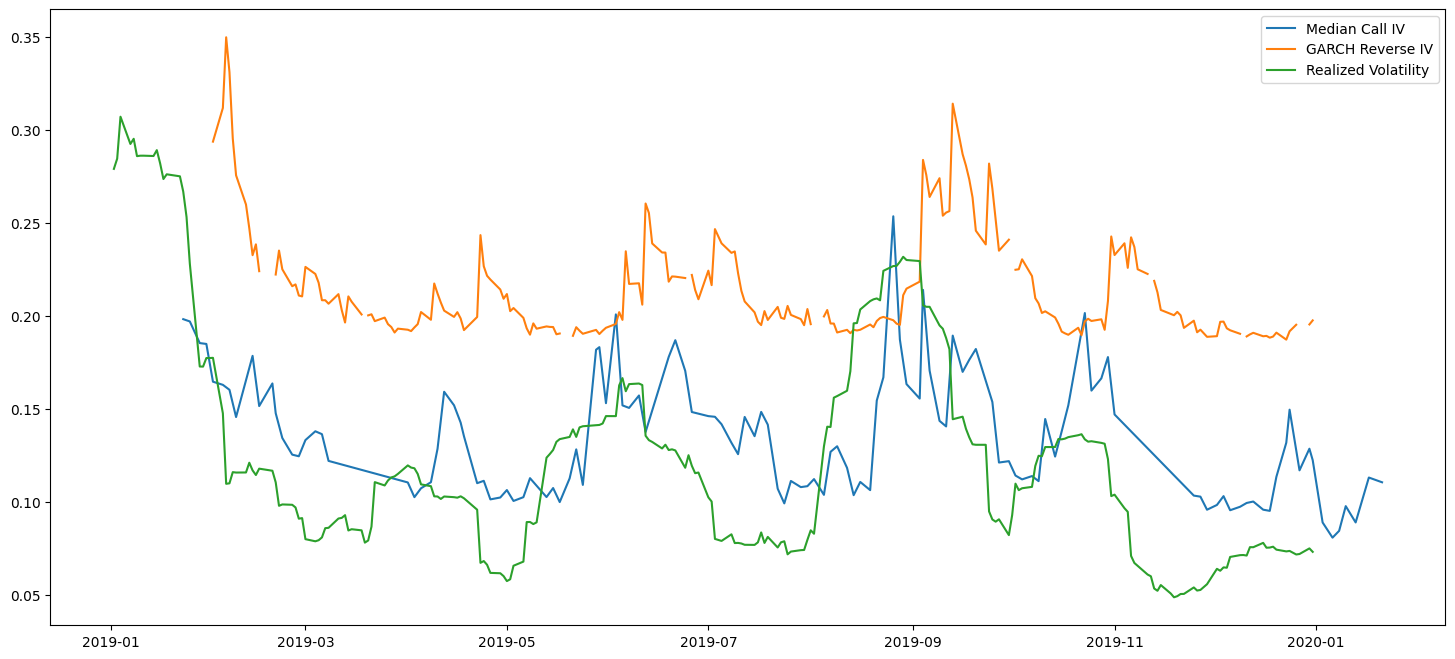

In [50]:
fig = plt.figure(figsize = (18,8))
plt.plot(iv_dist["C IV", "median"])
plt.plot(garch_pricing["Call IV ATM"])
plt.plot(spy_data["Realized Volatility"][split_date:])
plt.legend(["Median Call IV", "GARCH Reverse IV", "Realized Volatility"])

### 2.2 EGARCH Simulation

#### 2.2.0 Creating Model Simulations

In [51]:
egarch_forecaster = ARCHForecastModel("SPY", "2014-01-01", "2020-01-01", "2019-01-01", "EGARCH", 1, 1, 21)
egarch_forecaster.forecaster(21)
egarch_simulator = egarch_forecaster.simulation(21)

[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
Iteration:      1,   Func. Count:      6,   Neg. LLF: 12072648437473.748
Iteration:      2,   Func. Count:     15,   Neg. LLF: 3326895526440.9688
Iteration:      3,   Func. Count:     24,   Neg. LLF: 7759.433041546981
Iteration:      4,   Func. Count:     33,   Neg. LLF: 1417.951969472186
Iteration:      5,   Func. Count:     39,   Neg. LLF: 9250.549530906555
Iteration:      6,   Func. Count:     46,   Neg. LLF: 1374.4456407538785
Iteration:      7,   Func. Count:     51,   Neg. LLF: 1374.4448799109962
Iteration:      8,   Func. Count:     56,   Neg. LLF: 1374.4448782047484
Iteration:      9,   Func. Count:     60,   Neg. LLF: 1374.4448782049622
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1374.4448782047484
            Iterations: 9
            Function evaluations: 60
            Gradient evaluations: 9


In [52]:
egarch_pricing = egarch_forecaster.options_pricing(egarch_simulator,1, shift=True)
egarch_pricing.head()

,Call Price ATM,Realized Call Value ATM,Put Price ATM,Realized Put Value ATM,Underlying Price
Date,,,,,
2019-02-01,7.132405,18.320709,2.272065,0.0,230.557465
2019-02-04,7.488613,25.573410,2.732200,0.0,225.055725
2019-02-05,8.314706,19.085678,3.311301,0.0,232.594086
2019-02-06,7.934722,16.919891,3.004205,0.0,234.428040
2019-02-07,7.906480,12.321396,2.789430,0.0,236.630585


#### 2.2.1 Comparing Simulations to Realized Data

Call Analysis

<Axes: xlabel='EXPIRE DATE'>

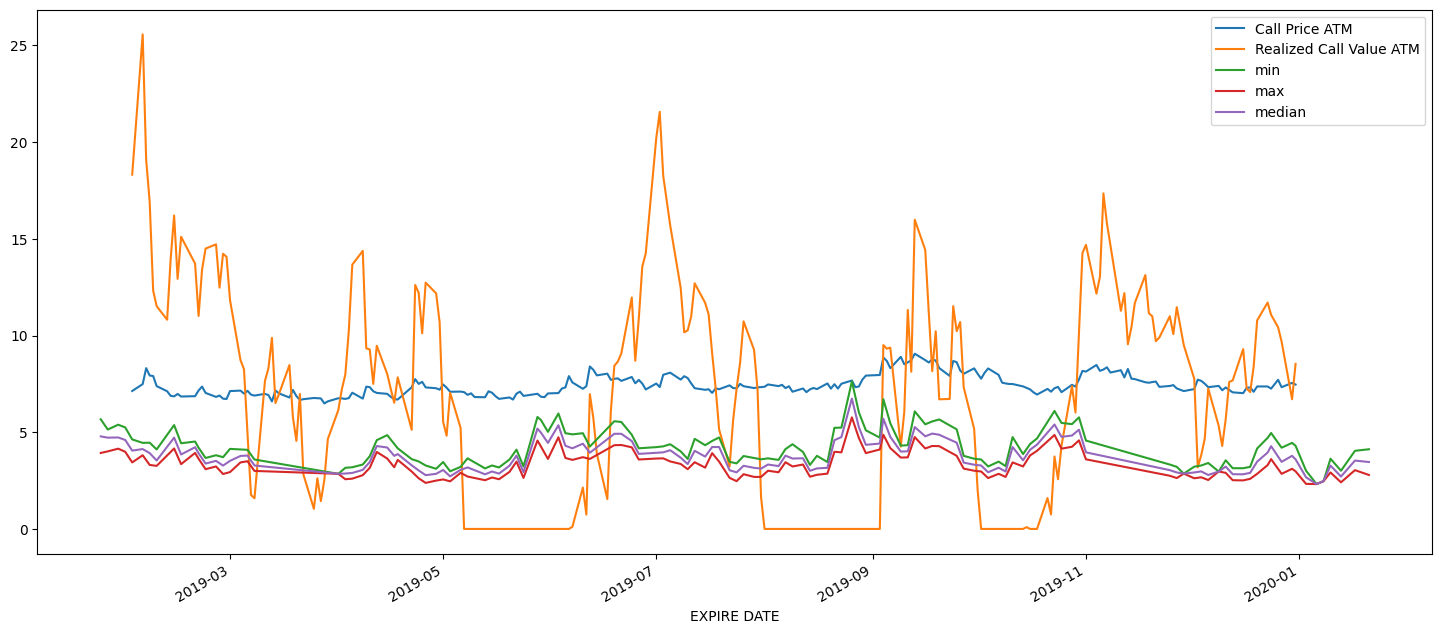

In [53]:
fig = plt.figure(figsize=(18,8))
ax = plt.axes()
egarch_pricing[["Call Price ATM", "Realized Call Value ATM"]].plot(ax=ax)
ask_dist["C ASK"].plot(ax=ax)

In [54]:
egarch_pricing["Forecasted Call Value Residuals"] = egarch_pricing["Call Price ATM"] - egarch_pricing["Realized Call Value ATM"]
call_ask_residuals = ask_dist["C ASK"]["median"] - garch_pricing["Realized Call Value ATM"]

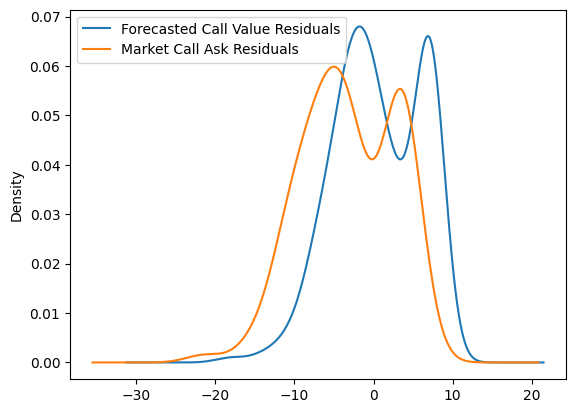

In [55]:
ax = plt.axes()
egarch_pricing["Forecasted Call Value Residuals"].plot(kind="kde", ax=ax)
call_ask_residuals.plot(kind="kde", ax=ax)
plt.legend(["Forecasted Call Value Residuals", "Market Call Ask Residuals"])

In [56]:
print(f"Regarding calls, the market ask price has a mean residual of {np.mean(call_ask_residuals)}\
 and a standard deviation of {np.std(call_ask_residuals)},\nthe EGARCH Model has a mean residual of\
 {np.mean(egarch_pricing['Forecasted Call Value Residuals'])} and a standard deviation of {np.std(egarch_pricing['Forecasted Call Value Residuals'])}")

Regarding calls, the market ask price has a mean residual of -3.158915482208508 and a standard deviation of 5.819085415588201,
the EGARCH Model has a mean residual of 0.5425199468968783 and a standard deviation of 5.401480265129948


Put Analysis

<Axes: xlabel='EXPIRE DATE'>

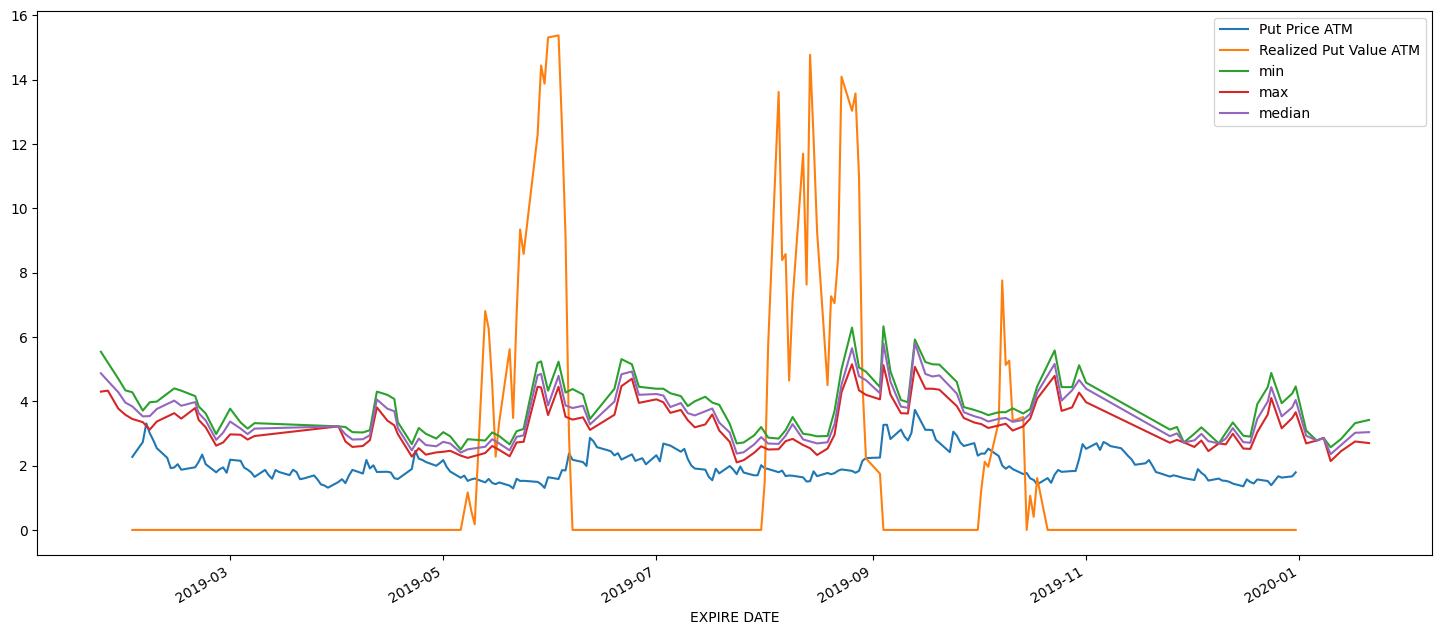

In [57]:
fig = plt.figure(figsize=(18,8))
ax = plt.axes()
egarch_pricing[["Put Price ATM", "Realized Put Value ATM"]].plot(ax=ax)
ask_dist["P ASK"].plot(ax=ax)

In [58]:
egarch_pricing["Forecasted Put Value Residuals"] = egarch_pricing["Put Price ATM"] - egarch_pricing["Realized Put Value ATM"]
put_ask_residuals = ask_dist["P ASK"]["median"] - garch_pricing["Realized Put Value ATM"]

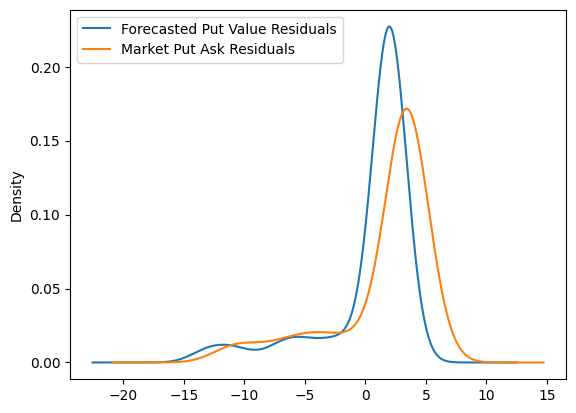

In [59]:
ax = plt.axes()
egarch_pricing["Forecasted Put Value Residuals"].plot(kind="kde", ax=ax)
put_ask_residuals.plot(kind="kde", ax=ax)
plt.legend(["Forecasted Put Value Residuals", "Market Put Ask Residuals"])

In [60]:
print(f"Regarding puts, the market ask price has a mean residual of {np.mean(put_ask_residuals)}\
 and a standard deviation of {np.std(put_ask_residuals)},\nthe EGARCH Model has a mean residual of\
 {np.mean(egarch_pricing['Forecasted Put Value Residuals'])} and a standard deviation of {np.std(egarch_pricing['Forecasted Put Value Residuals'])}")

Regarding puts, the market ask price has a mean residual of 1.456157303497571 and a standard deviation of 4.156461390654912,
the EGARCH Model has a mean residual of 0.33252637845901256 and a standard deviation of 3.848869634623583


This framework can be used for backtesting by altering the maturity and the moneyness of the forecast and simulation